# Generating melodies with RNN LSTM

In [1]:
import torch
from torch import nn, optim
from model import LSTM
import torch.nn
from preprocess import PreProcessor
from dataset import MusicDataset, split_train_validation
import numpy as np
from torch.utils.data import DataLoader
from training import Trainer
from melody_generation import MelodyGenerator
from IPython.display import Image
from experiments import optimizers_exp, hidden_size_exp


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}...")

Using cpu...


# Pre Process

First of all we have to process the midi files into int vectors.
For the demonstration we will use a 12 midi files.

You may try with larger number of files.

In [2]:
# pre processing the dataset
pre = PreProcessor('dataset/deutschl/test', 'processed_dataset')
songs = pre.process()
print(f"{songs=}")

loading files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 287.58it/s, file=deut5149.krn]

Loaded 12 songs.
Encoding the dataset into time series representation files...
Generating single file dataset & unique mapping...
processed_dataset/mapping.json - JSON mapping file created!
songs=array([ 4, 13,  4, ..., 14, 14, 14])


# Data sets and loaders

We use the MusicDataSet as a costum dataset which turns the sequences into one hot vectors any time a batch is drawn from it.

We take the whole data and split it into train and validation data sets in order to train the model on different data than our validation data.

In [3]:
# splitting the data to train and validation sets
train_ids, validation_ids = split_train_validation(np.arange(len(songs) - pre.seq_len))

training_set = MusicDataset(train_ids, songs, pre.mapping_file)
train_loader = DataLoader(training_set, batch_size=64, shuffle=True)

validation_set = MusicDataset(validation_ids, songs, pre.mapping_file)
validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)



# Model

In [4]:
model = LSTM(training_set.vocabulary_size, 256, training_set.vocabulary_size, pre.mapping_file)

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

# Experiments

We have experimented kfold with cross validation of different hidden sizes and optimisers and have decided to use hidden size of 256 and adam as our optimiser.

As you can see hidden sizes of 256, 512, 1024 have done well in terms of accuracy **BUT** the higher the hidden size the more time the training consumes, therefore we chose 256 as our jack of all trades.

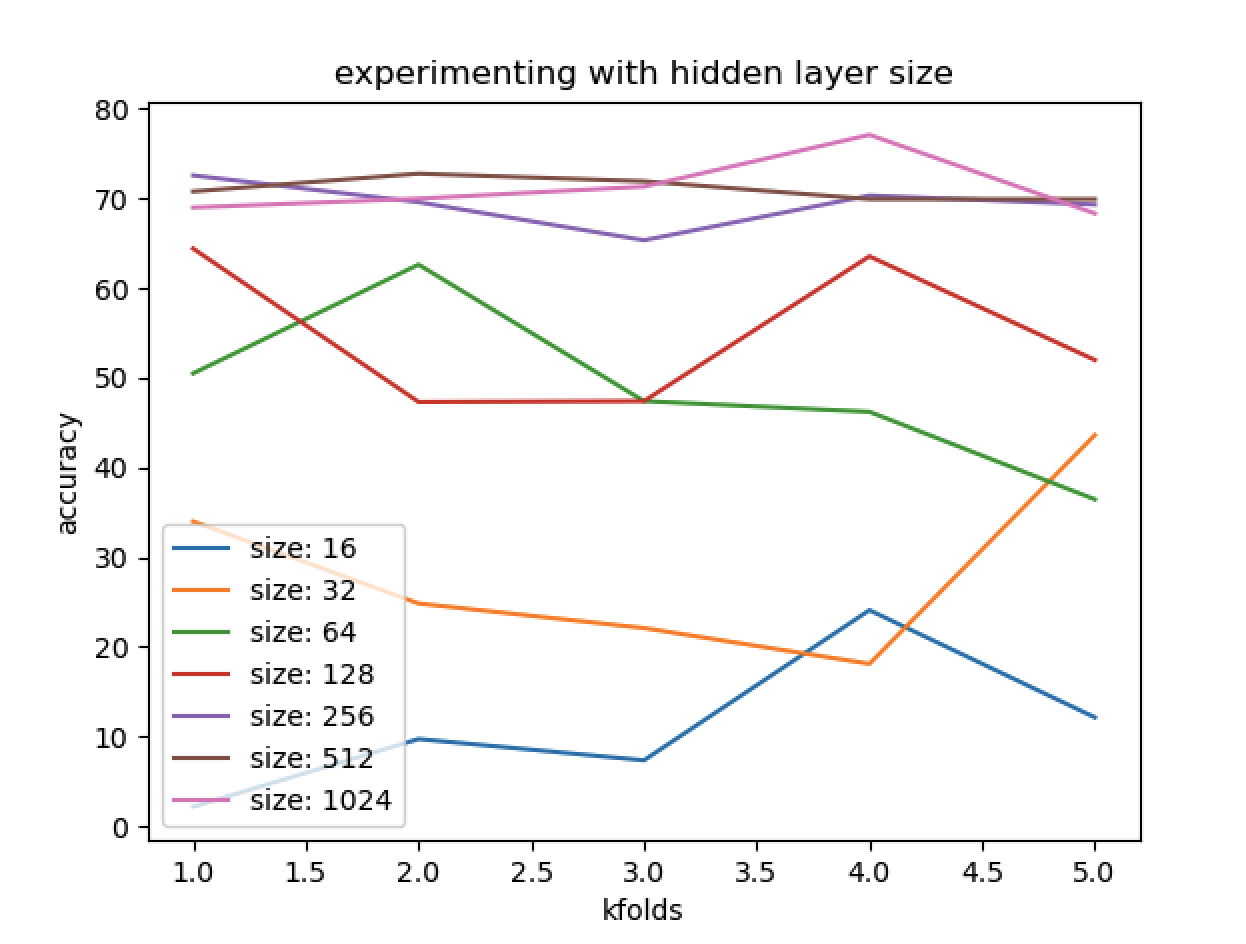

In [5]:
Image(filename='experiment_graphs/hidden_size.png', width=600, height=600)

As for the optimiser you can see that SGD is clearly not a good option but we could choose freely from RMS and ADAM.

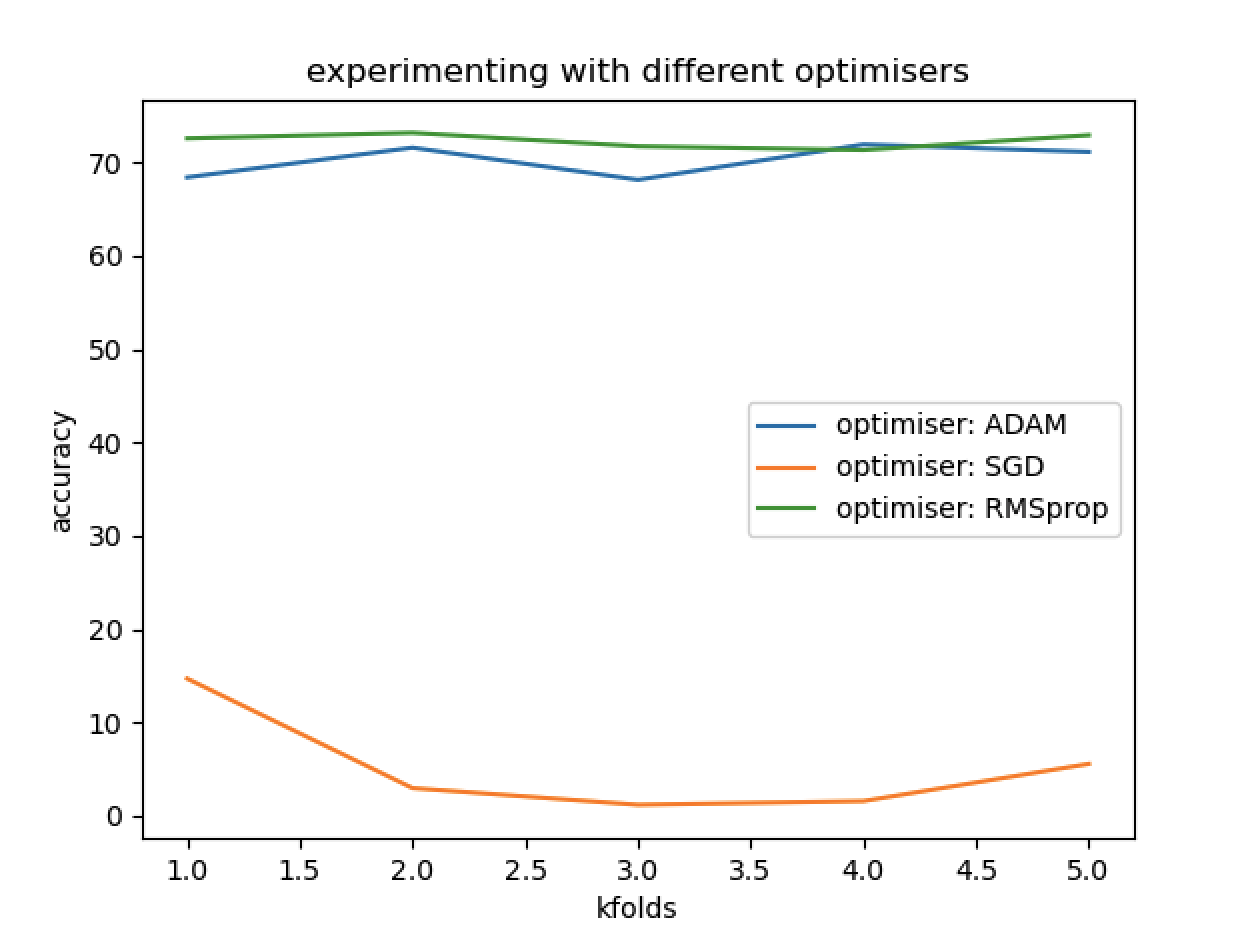

In [6]:
Image(filename='experiment_graphs/optimisers.png', width=600, height=600)

You can run the experiments and change its params on your own if you'd like by uncommenting those lines of code

In [7]:
# uncomment to run experiments
# check the experiments.py file for additional args

# optimizers_exp()

# hidden_size_exp()

# Training

In [8]:
trainer = Trainer(model, optimiser, criterion, device=device)
trainer.fit(train_loader, validation_loader, epoches=50)

Epoch [49/50] Step [35/36]: 100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [02:07<00:00,  2.55s/it, acc=92.5, loss=0.00177]


# Generating Melody

You may run this cell again to generate another melody!

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): image not found 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/md/n48mlyhj0r37qxr7gg850hpr0000gn/T/music21/tmpa2vmegwl.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/md/n48mlyhj0r37qxr7gg850hpr0000gn/T/music21/tmpa2vmegwl.png>
... success!


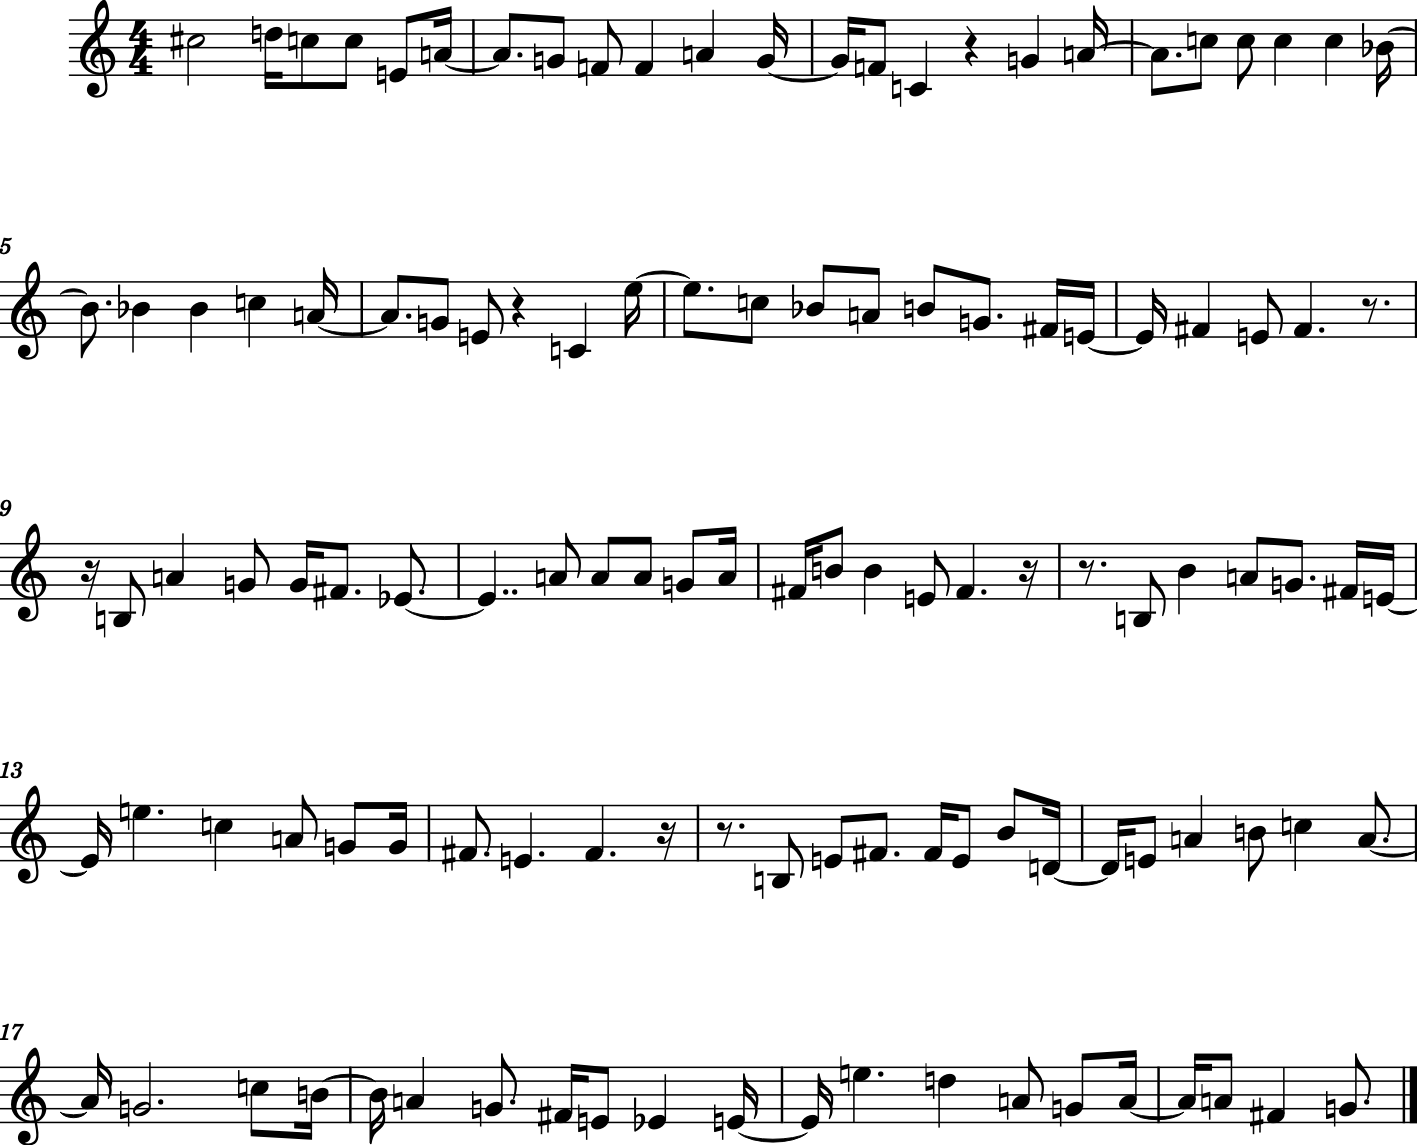

In [9]:
gen = MelodyGenerator('trained_models')
song = gen.generate_melody(500, 64, 0.85)
midi = gen.save_melody(song)

midi.show()
midi.show('midi')

# Generating melody using a pre trained model

dlopen error : dlopen(libjack.0.dylib, 1): image not found 
dlopen error : dlopen(/usr/local/lib/libjack.0.dylib, 1): image not found 
Creating main window…
ZoomBox::setLogicalZoom(): Formatting logical zoom level as 100% (rounded from 1.000000)
Reading translations…
convert </var/folders/md/n48mlyhj0r37qxr7gg850hpr0000gn/T/music21/tmp5x7gua4s.xml>...
JIT is disabled for QML. Property bindings and animations will be very slow. Visit https://wiki.qt.io/V4 to learn about possible solutions for your platform.
	to </var/folders/md/n48mlyhj0r37qxr7gg850hpr0000gn/T/music21/tmp5x7gua4s.png>
... success!


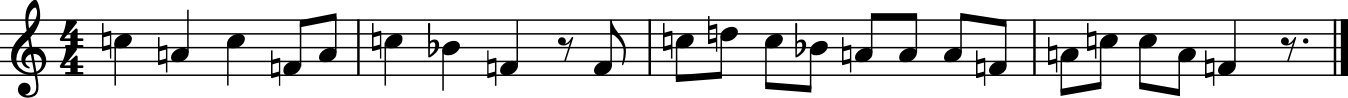

In [10]:
gen = MelodyGenerator('trained_models/trained_erk')
song = gen.generate_melody(500, 64, 0.85)
midi = gen.save_melody(song)

midi.show()
midi.show('midi')